## 유동인구 + Index 데이터 분석(feat.지역구 별 cnt)



집단발생 유무에 따라 각 지역구별 유동인구수의 변화를 확인한다. 그래서 유동인구의 변화가 cgi와 cnt에도 영향을 미치는지 알아보려 한다. 검은색 선이 포스트 코로나 전 후를 표시한다.



### 집단감염에 따른 유동인구 변화

In [ ]:
#행정구역 데이터 전처리
adstrd.columns = ['행정동코드','행정동명','시도명','자치구명'] 
adstrd_seoul = adstrd.loc[adstrd.시도명=='서울특별시',['행정동코드','자치구명']]
adstrd_seoul['행정동코드']=adstrd_seoul['행정동코드'].astype(int)

In [ ]:
#유동인구 데이터 전처리
new_fpop=fpop_df[["base_ymd","agrde_se_code","sexdstn_se_code","adstrd_code","popltn_cascnt"]]
new_fpop.columns=["기준일","연령대","성별","행정동코드","유동인구수"]
new_fpop_seoul=new_fpop.merge(adstrd_seoul, how='left', on='행정동코드').drop(columns='행정동코드')
new_fpop_seoul['주차'] = pd.to_datetime(new_fpop_seoul['기준일'], format='%Y%m%d').dt.weekofyear
new_fpop_seoul_gu=new_fpop_seoul.groupby(["자치구명","기준일"])["유동인구수"].sum().reset_index()
new_fpop_seoul_gu["기준일"]=pd.to_datetime(new_fpop_seoul_gu['기준일'], format='%Y%m%d')
new_fpop_seoul_gu['월'] =new_fpop_seoul_gu['기준일'].dt.month
new_fpop_seoul_gu['주차'] = new_fpop_seoul_gu['기준일'].dt.weekofyear
new_fpop_seoul_gu = new_fpop_seoul_gu.groupby(['자치구명','월', '주차'])['유동인구수'].mean().reset_index()
covid_case_seoul_mass_sorted_with_date.rename(columns = {'weekday' : '주차'}, inplace = True)

In [ ]:
#유동인구 및 집단감염 발생일 그래프 함수
def plot_fpop_gu(df,df2, time_bin="주차", region="용산구"):
  """
    time_bin = '주차' or '월'
    region = '전국' or '서울'
  """
  col=region
  tmp_df = df[df.자치구명==col]
  tmp_df["유동인구수"]=tmp_df["유동인구수"].divide(1000000).round(2)
  tmp_df.drop(columns="자치구명", inplace=True)
  tmp_df=tmp_df.groupby(time_bin)["유동인구수"].mean().to_frame().reset_index()



  plt.rcParams["figure.figsize"] = (25,10)
  ax = plt.gca()
  ax2=ax.twinx()
  df2=df2[df2.city==col]
  for i in range(len(df2)):
    ax2.bar(df2["주차"].iloc[i],df2["confirmed"].iloc[i],color="red", label=str(i+1)+" "+df2["infection_case"].iloc[i]+" "+df2["city"].iloc[i], width = 0.25)
    plt.text(df2["주차"].iloc[i], df2["confirmed"].iloc[i], str(i+1),va="bottom", fontsize=15)


  ax.plot(tmp_df[time_bin],tmp_df["유동인구수"],label='유동인구수')
  ax.set_ylim(0.8,3.2)

  handles, labels = ax.get_legend_handles_labels()
  patch = mpatches.Patch(color='grey', label='코로나 확산지점')
  handles.append(patch) 
  
  plt.legend(loc="upper left", ncol = 2, fontsize=15)
  plt.title(f'{region} 유동인구 변화', size=30)
  plt.xticks(rotation=0, size=20, ha='right')
  if time_bin!="주차":
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
  else: # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=1.0) 
    ax.xaxis.set_major_locator(loc)
  plt.axvline(8, color='grey')
  plt.xlabel(time_bin, size=25)
  ax.set_ylabel("유동인구수 (100만)", size=25, color='b')
  ax2.set_ylabel( '집단감염 총 확진자 수', size=25, color='r')
  ax.legend(handles=handles,loc="upper center", ncol = 2, fontsize=15)
  plt.show()
  return

In [ ]:
#index 기간 설정 및 분석 나이 기준 정하기
index['date'] = pd.to_datetime(index['period'], format = "%Y%m")
index_age = index[(index['sigungu'] == 'all') & (index['gender'] == 'all')].groupby(['date','age'], as_index = False).mean()

In [ ]:
#행정동 코드 바꾸기
card['행정동코드'] = card['행정동코드']/100
card['행정동코드'] = card['행정동코드'].astype(int)

In [ ]:
#주차 생성
card_ad = card.merge(adstrd_seoul,how = 'left',on = '행정동코드').drop(columns='행정동코드')
card_ad['주차'] = card_ad['date'].dt.weekofyear

### 집단 감염이 있는 지역

---



집단감염에 의한 확진자의 수가 많은 구의 유동인구와 거기에 따른 소비수치의 변화를 확인한다. 집단감염의 유무를 떠나서 포스트코로나 시작시점인 코로나 확산일에 모든 구들의 유동인구가 줄어든다.

서울 내 집단감염의 영향을 가장 크게 받은 구역들로는 구로구 콜센터가 위치한 구로구, 방문판매업체 리치웨이의 관악구, 이태원 클럽의 용산구를 중심으로 분석했다. 

1. 구로구



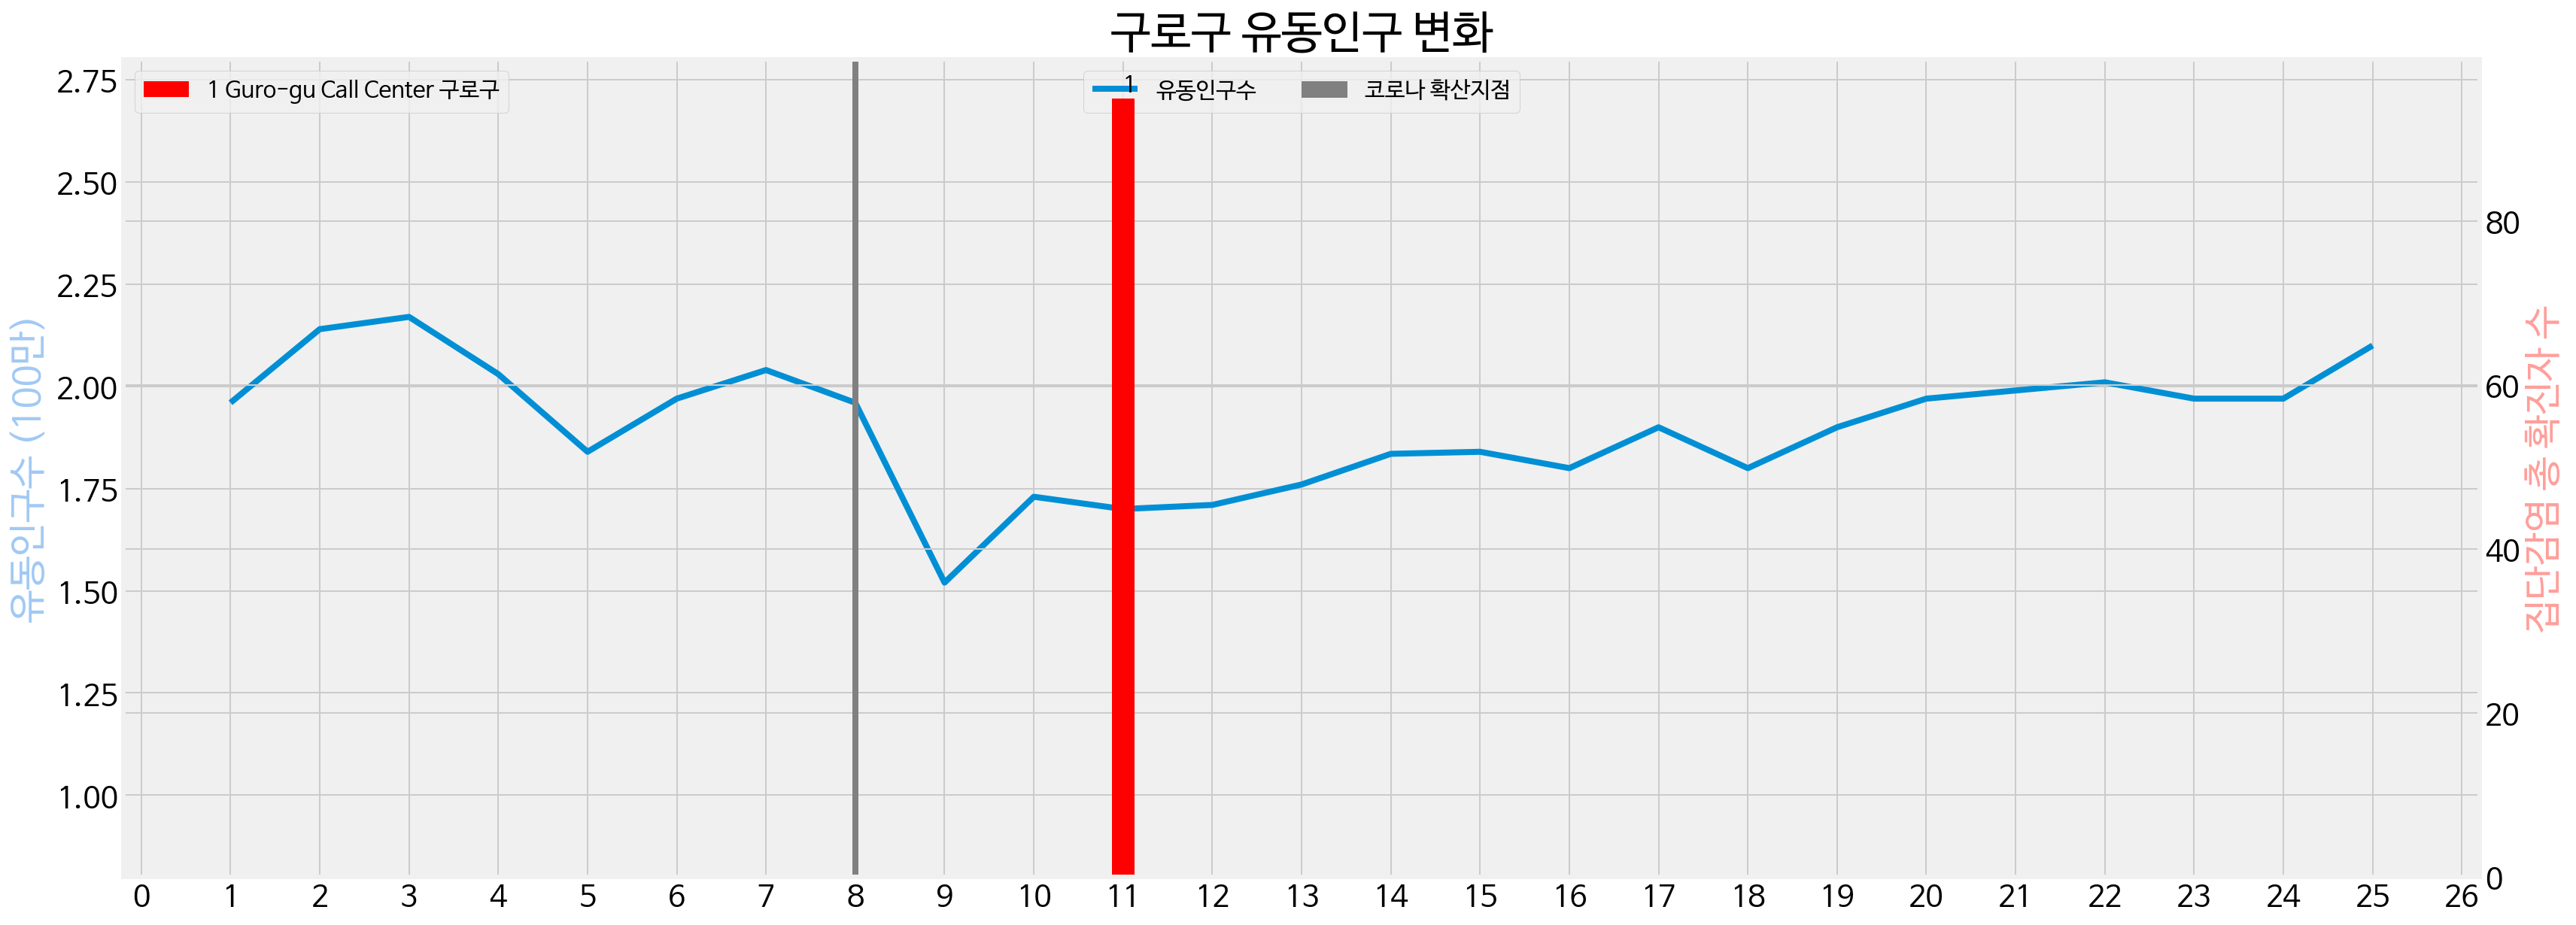

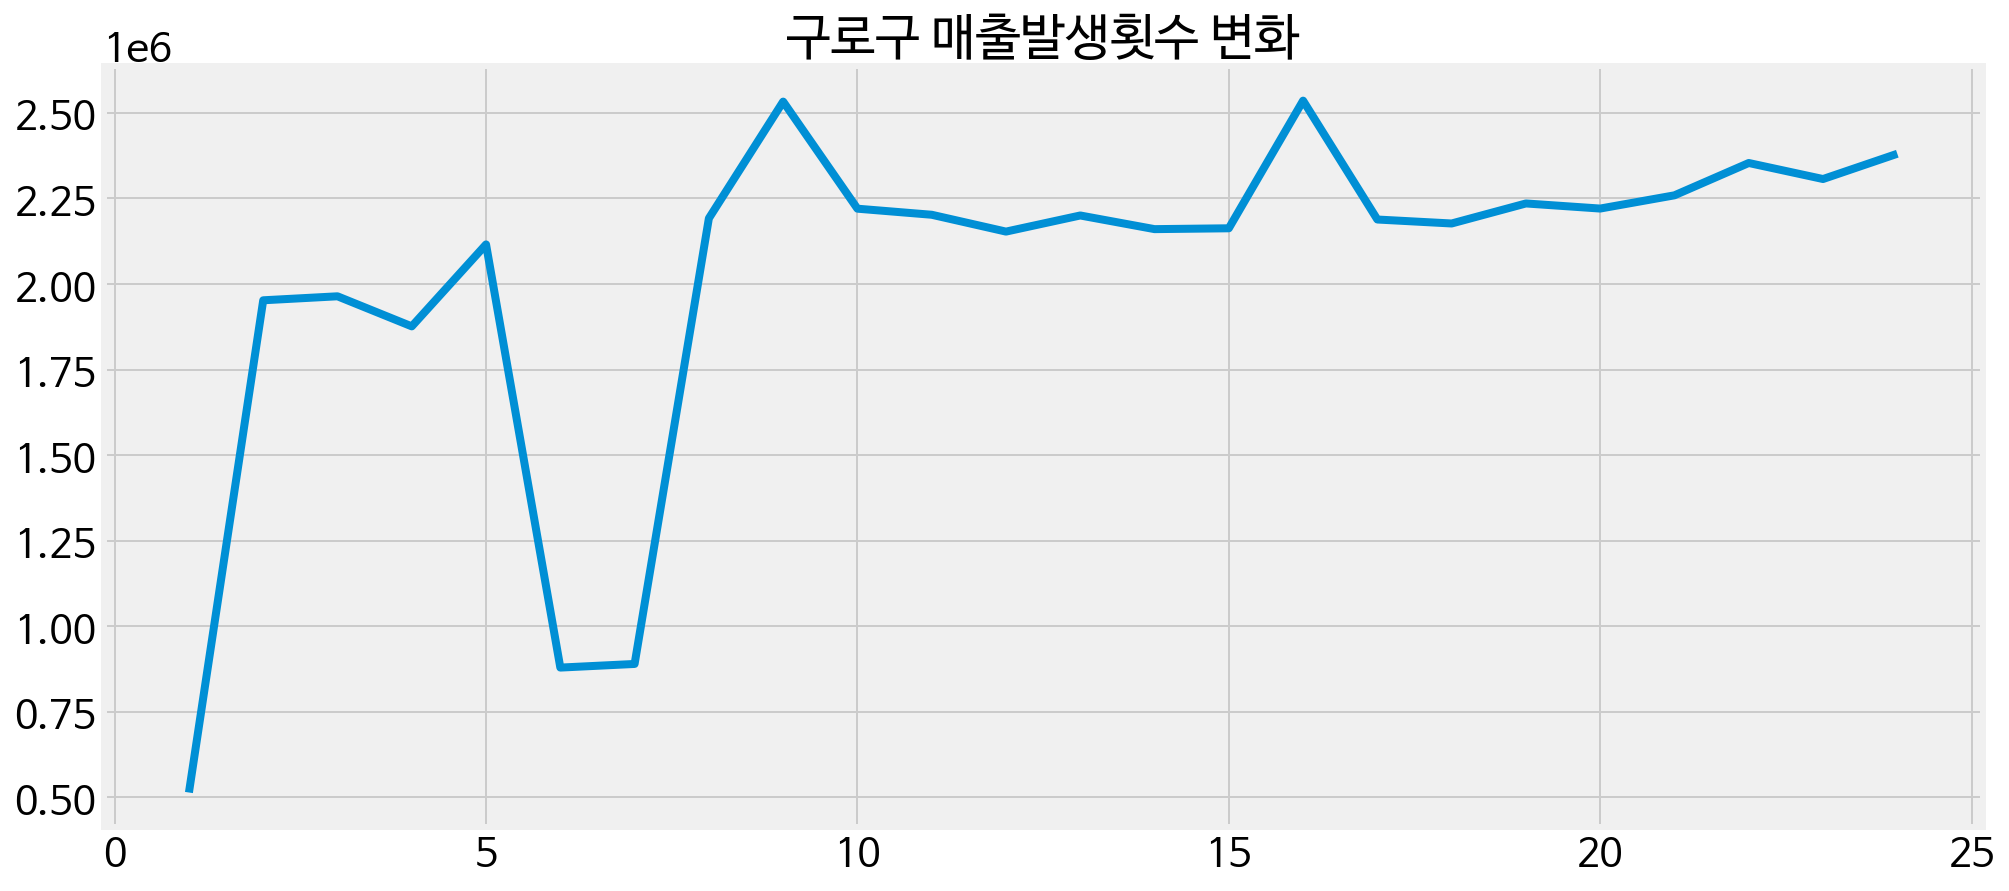

In [ ]:
#구로구 유동인구
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="구로구")

#구로구 cgi 변화
index_region=index.loc[index['sigungu']=="구로구",:]
index_region=index_region[['date','cgi']]
index_region['cgi']=pd.to_numeric(index_region['cgi'])
index_region = index_region.groupby('date')['cgi'].mean().to_frame().reset_index()

fig = px.line(index_region, x='date', y='cgi', title = '구로구 cgi 변화')
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-02-18', x1= '2020-02-18',
    )
])
fig.show()

#구로구 cnt 변화
card_gwan=card_ad.loc[card_ad.자치구명=='구로구']
card_gwan=card_gwan[['주차','cnt']]
card_gwan['cnt']=pd.to_numeric(card_gwan['cnt'])
card_gwan=card_gwan.groupby('주차')['cnt'].sum().to_frame().reset_index()


#그래프 그리기
plt.rcParams['figure.figsize'] = (15,7)
fig = plt.figure()
plt.title("구로구 매출발생횟수 변화", fontsize=25)
plt.plot(card_gwan['주차'],card_gwan['cnt'])
plt.show()

구로구콜센터 집단감염 발병 주인 11주에 유동인구와 매출발생횟수 모두 전 주에 비교해 줄어들었다. 
그 후로 13주부터 유동인구는 천천히 증가하지만 매출발생횟수는 15주까지 감소된 채 유지되다가 15주 증가했다.
유동인구의 증가가 매출에 영향을 주기 까지 일정의 기간 소요되는 것을 확인할 수 있다. 그러나 콜센터 내 집단감염으로 인해 콜센터 내 직원의 수가 줄어들고 자택근무가 늘어남으로서 유동인구의 증가세가 높지 않은 것으로 분석할 수 있다. 
카테고리 성장지수 또한 포스트코로나 기간부터 100이하 수치로 작년보다 매출이 줄어들었다

2. 관악구

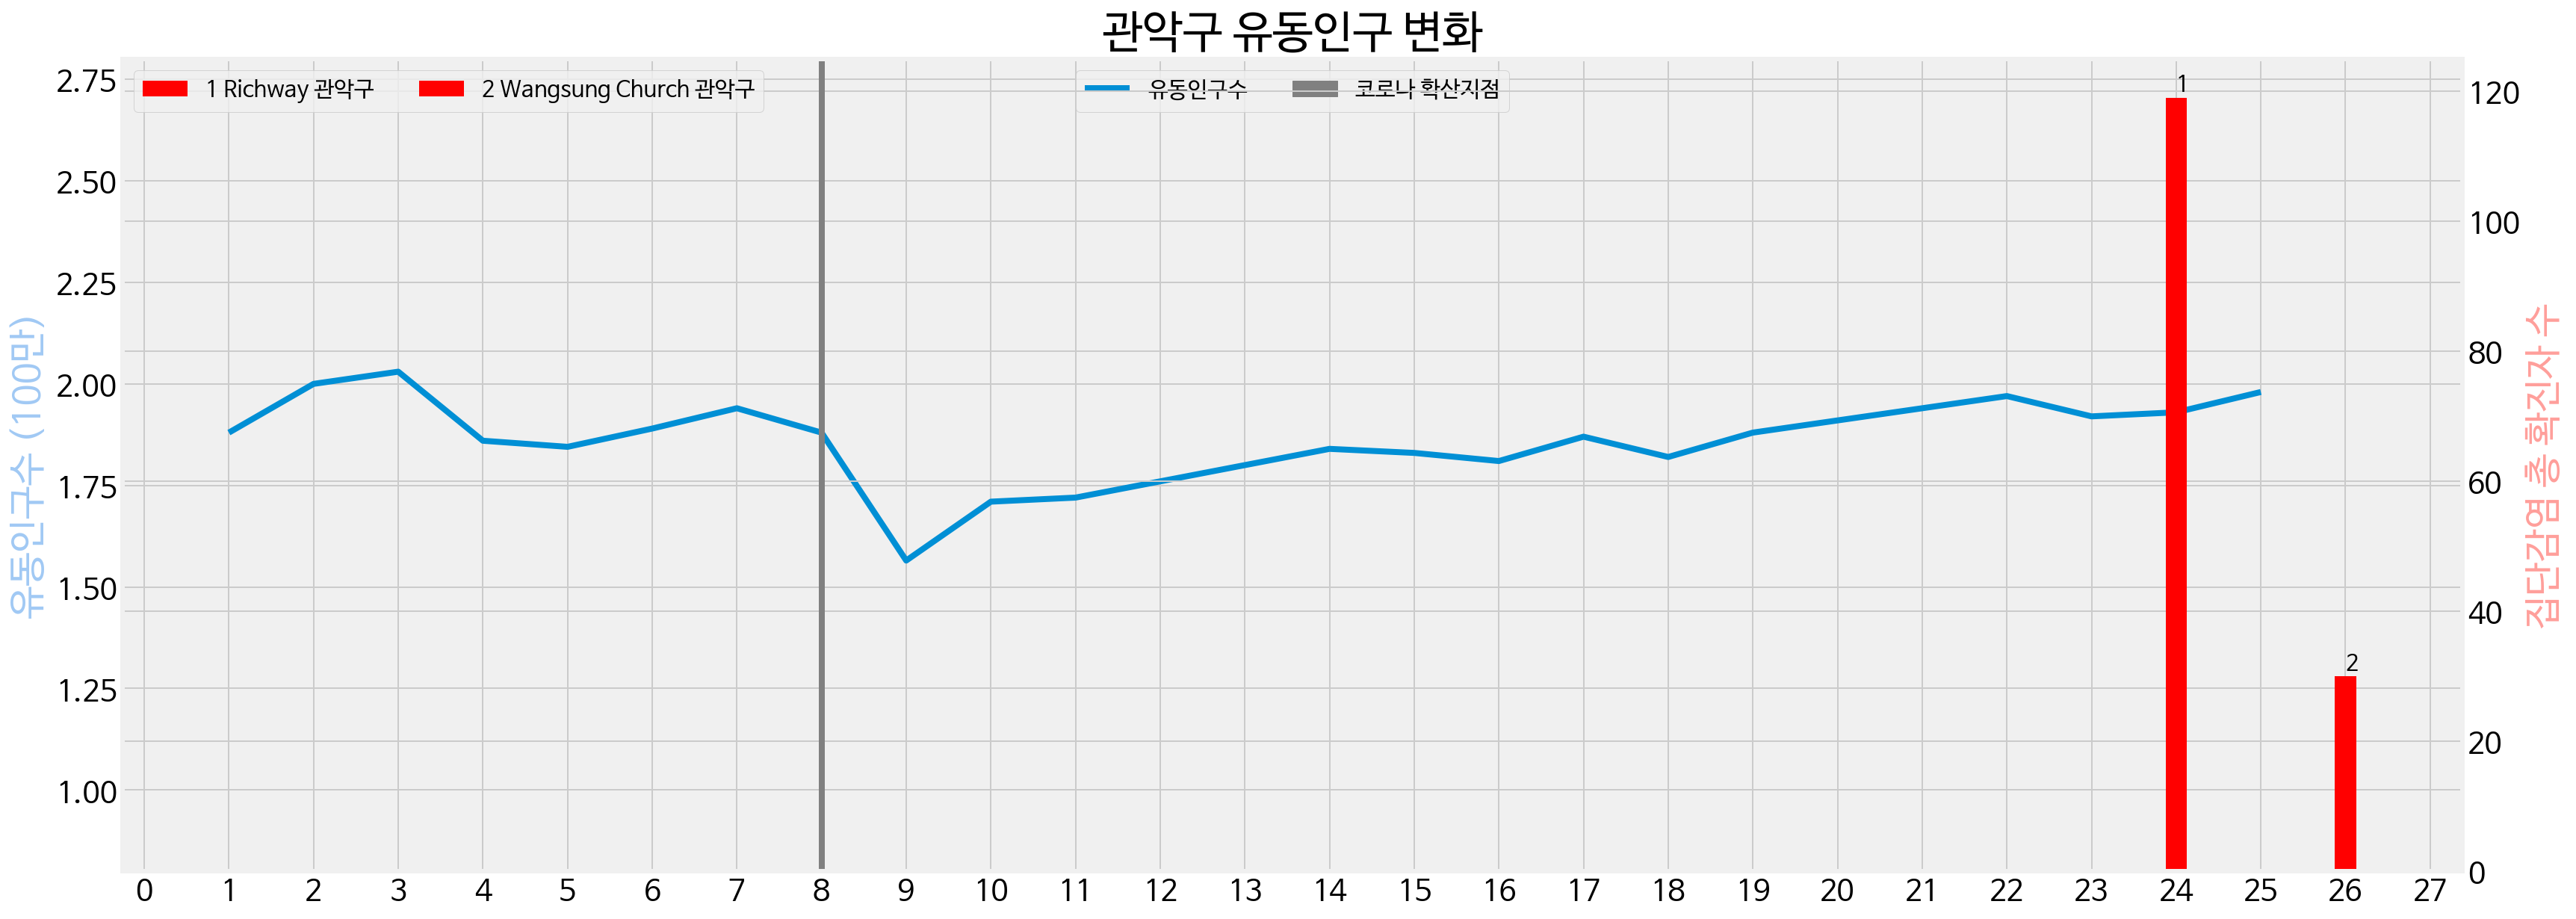

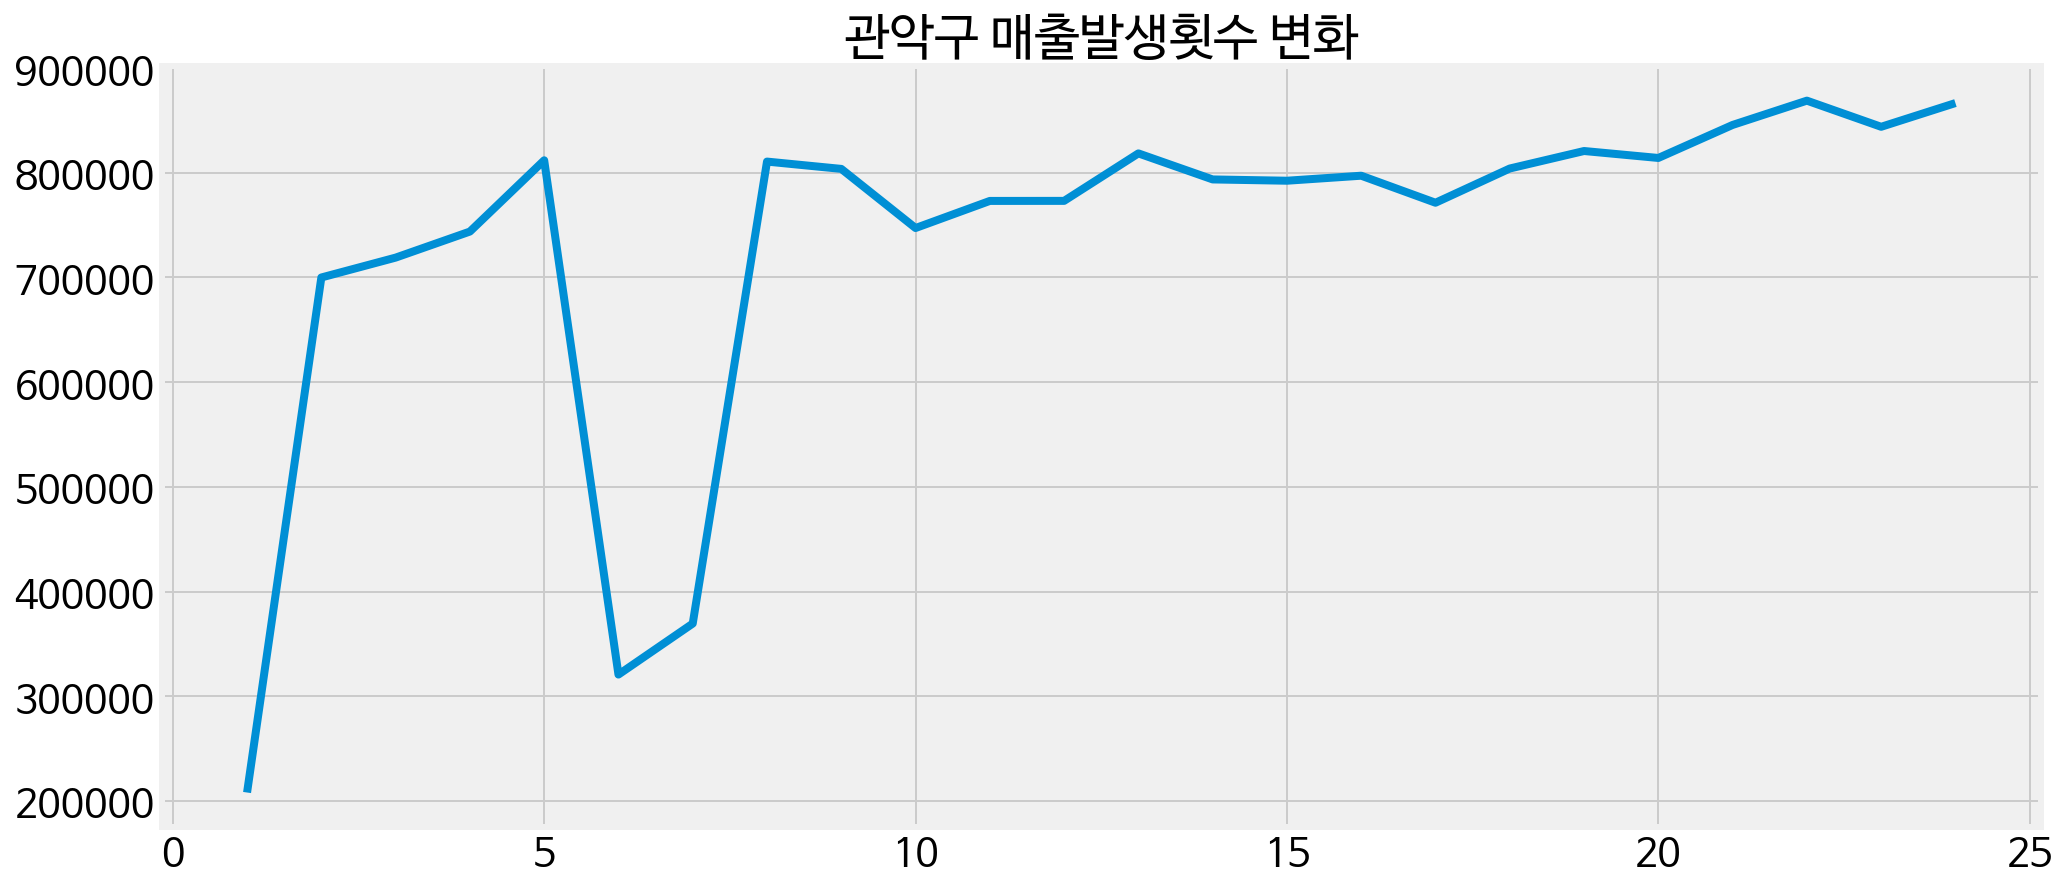

In [ ]:
#관악구 유동인구
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="관악구")

#관악구 cgi 변화
index_region=index.loc[index['sigungu']=="관악구",:]
index_region=index_region[['date','cgi']]
index_region['cgi']=pd.to_numeric(index_region['cgi'])
index_region = index_region.groupby('date')['cgi'].mean().to_frame().reset_index()

fig = px.line(index_region, x='date', y='cgi', title = '관악구 cgi 변화')
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-02-18', x1= '2020-02-18',
    )
])
fig.show()

#관악구 cnt 변화
card_gwan=card_ad.loc[card_ad.자치구명=='관악구']
card_gwan=card_gwan[['주차','cnt']]
card_gwan['cnt']=pd.to_numeric(card_gwan['cnt'])
card_gwan=card_gwan.groupby('주차')['cnt'].sum().to_frame().reset_index()


#그래프 그리기
plt.rcParams['figure.figsize'] = (15,7)
fig = plt.figure()
plt.title("관악구 매출발생횟수 변화", fontsize=25)
plt.plot(card_gwan['주차'],card_gwan['cnt'])
fig.show()

관악구 리치웨이 방문판매업체 집단감염 발병 주인 24주차에 유동인구와 매출발생횟수 모두 2,3주 전과 비교했을 때 줄어들었다. 
그 후로 유동인구와 매출발생횟수는 다시 증가한다.
관악구 리치웨이 집단감염의 경우 한 기업에 제한되어 있었기 때문에 구로구와 비교해서 영향이 적을 수 있다.
카테고리 성장지수 또한 포스트코로나 기간부터 100이하 수치로 작년보다 매출이 줄어들었다.

3. 용산구

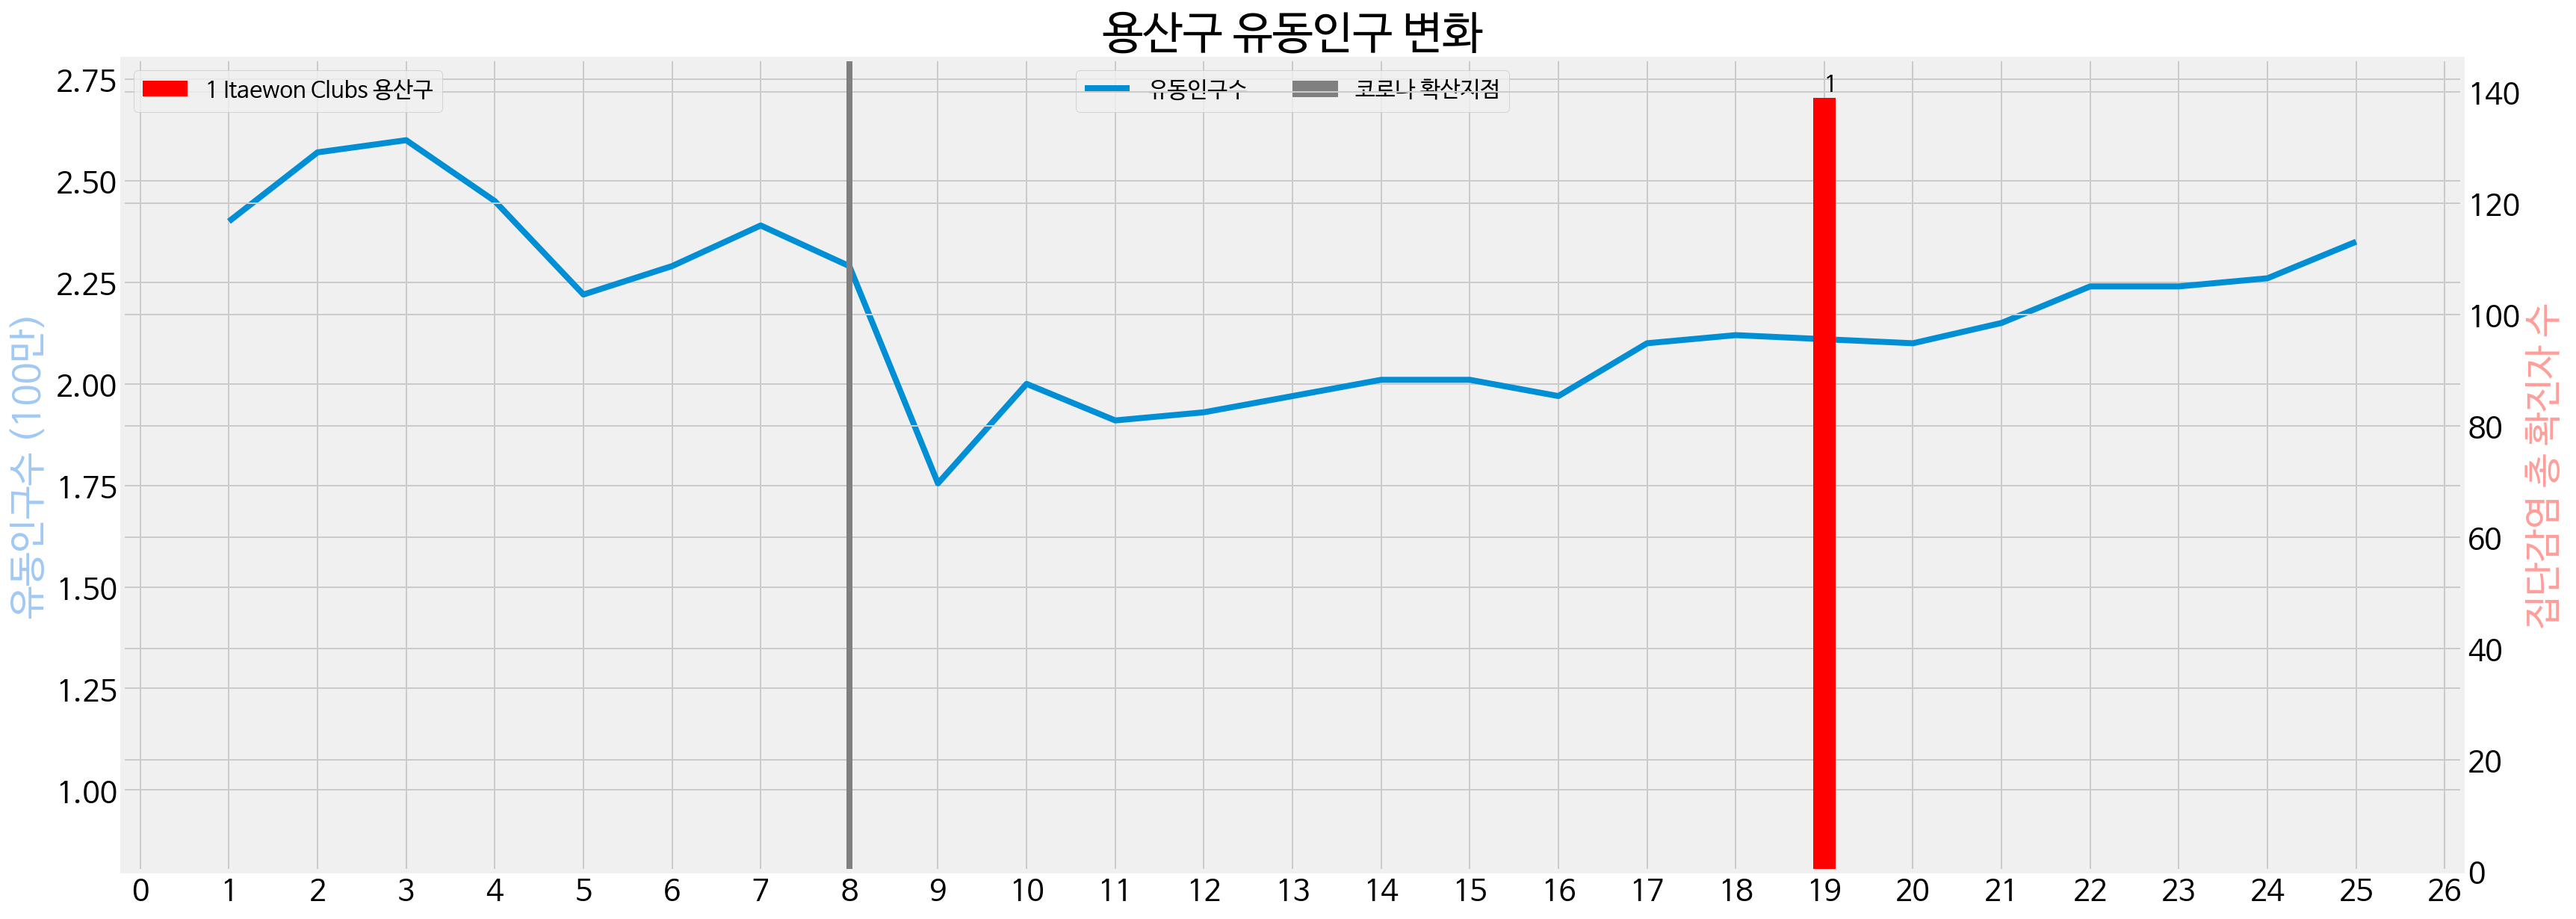

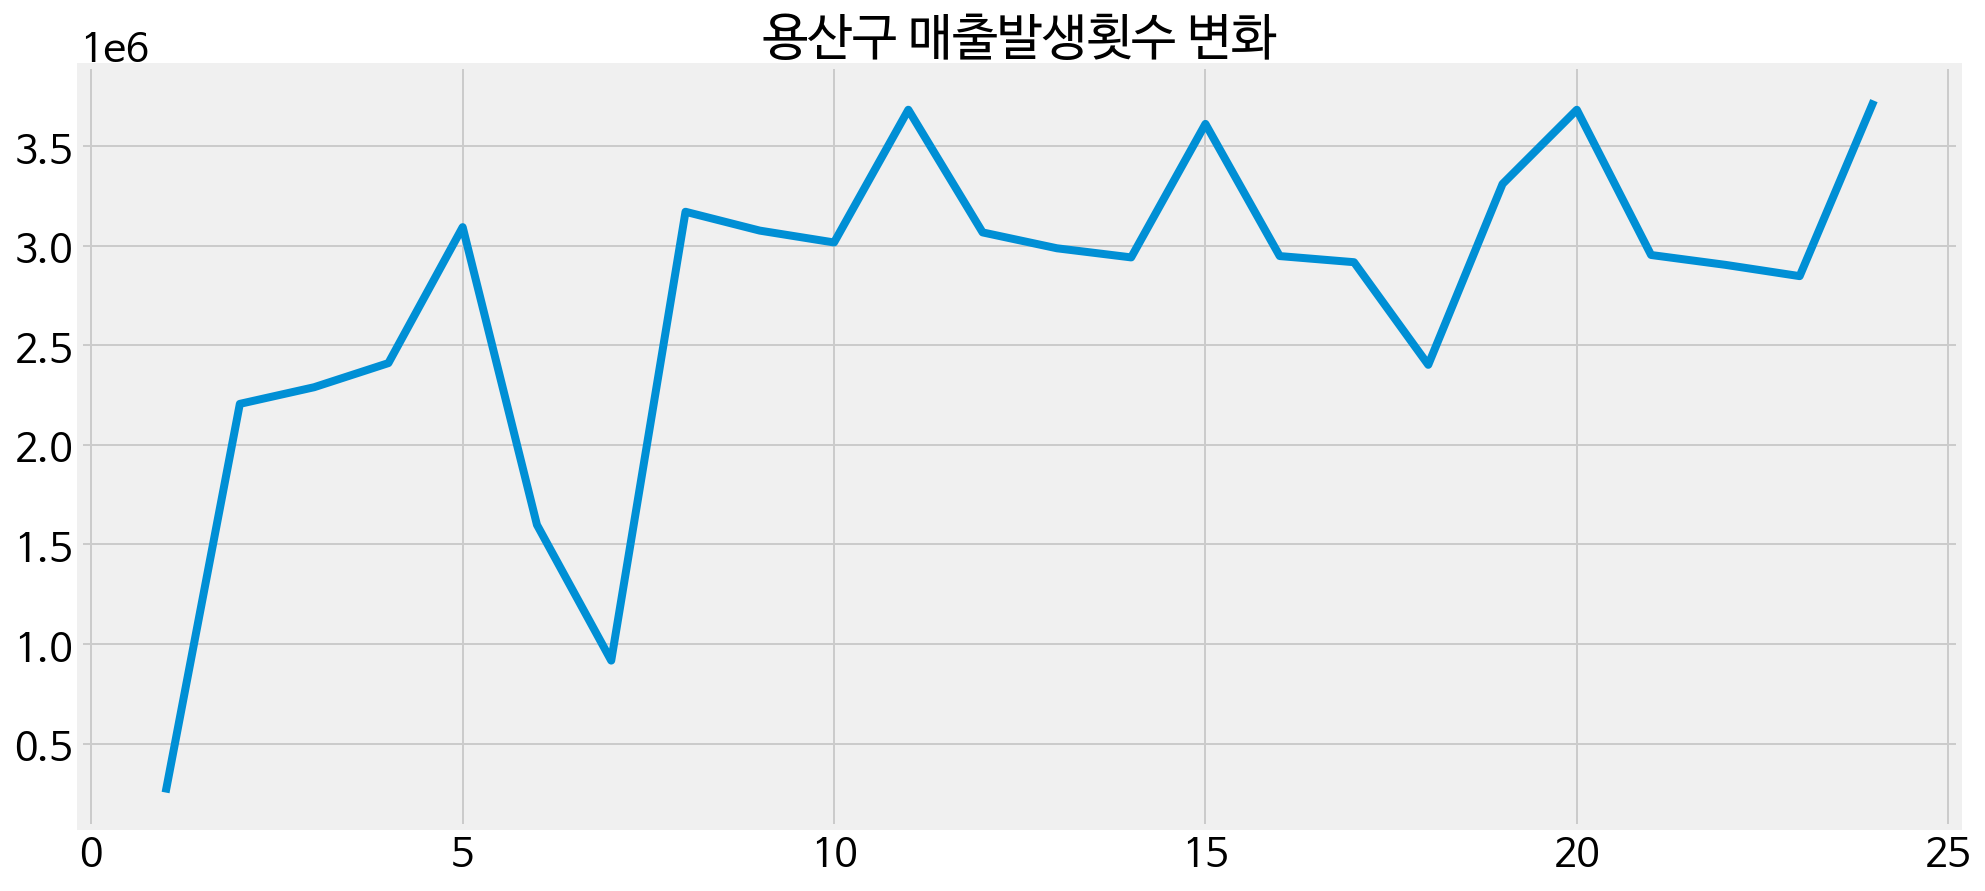

In [ ]:
#용산구 유동인구
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="용산구")

#용산구 cgi 변화
index_region=index.loc[index['sigungu']=="용산구",:]
index_region=index_region[['date','cgi']]
index_region['cgi']=pd.to_numeric(index_region['cgi'])
index_region = index_region.groupby('date')['cgi'].mean().to_frame().reset_index()

fig = px.line(index_region, x='date', y='cgi', title = '용산구 cgi 변화')
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-02-18', x1= '2020-02-18',
    )
])
fig.show()

#용산구 cnt 변화
card_gwan=card_ad.loc[card_ad.자치구명=='용산구']
card_gwan=card_gwan[['주차','cnt']]
card_gwan['cnt']=pd.to_numeric(card_gwan['cnt'])
card_gwan=card_gwan.groupby('주차')['cnt'].sum().to_frame().reset_index()


#그래프 그리기
plt.rcParams['figure.figsize'] = (15,7)
fig = plt.figure()
plt.title("용산구 매출발생횟수 변화", fontsize=25)
plt.plot(card_gwan['주차'],card_gwan['cnt'])
fig.show()

용산구 이태원 클럽 집단감염 발병 주인 19주차에 유동인구수는 약간 감소였지만 다른 20주차에 다 증가하기 시작했다. 
매출발생횟수 모두 19주차에는 증가세였지만 20주차에 다시 급속히 감소했고 23주까지 하락세를 보이다가 다시 증가했다. 
유동인구의 변화와 매출발생횟수의 변화 사이에 일정 기간이 있는 것은 구로구 데이터와 일치했다.
카테고리 성장지수 또한 포스트코로나 기간부터 100이하 수치로 작년보다 매출이 줄어들었는데 하락세를 꾸준히 유지하고 있다. 

### 집단 감염이 없는 지역

---



1. 강서구

No handles with labels found to put in legend.


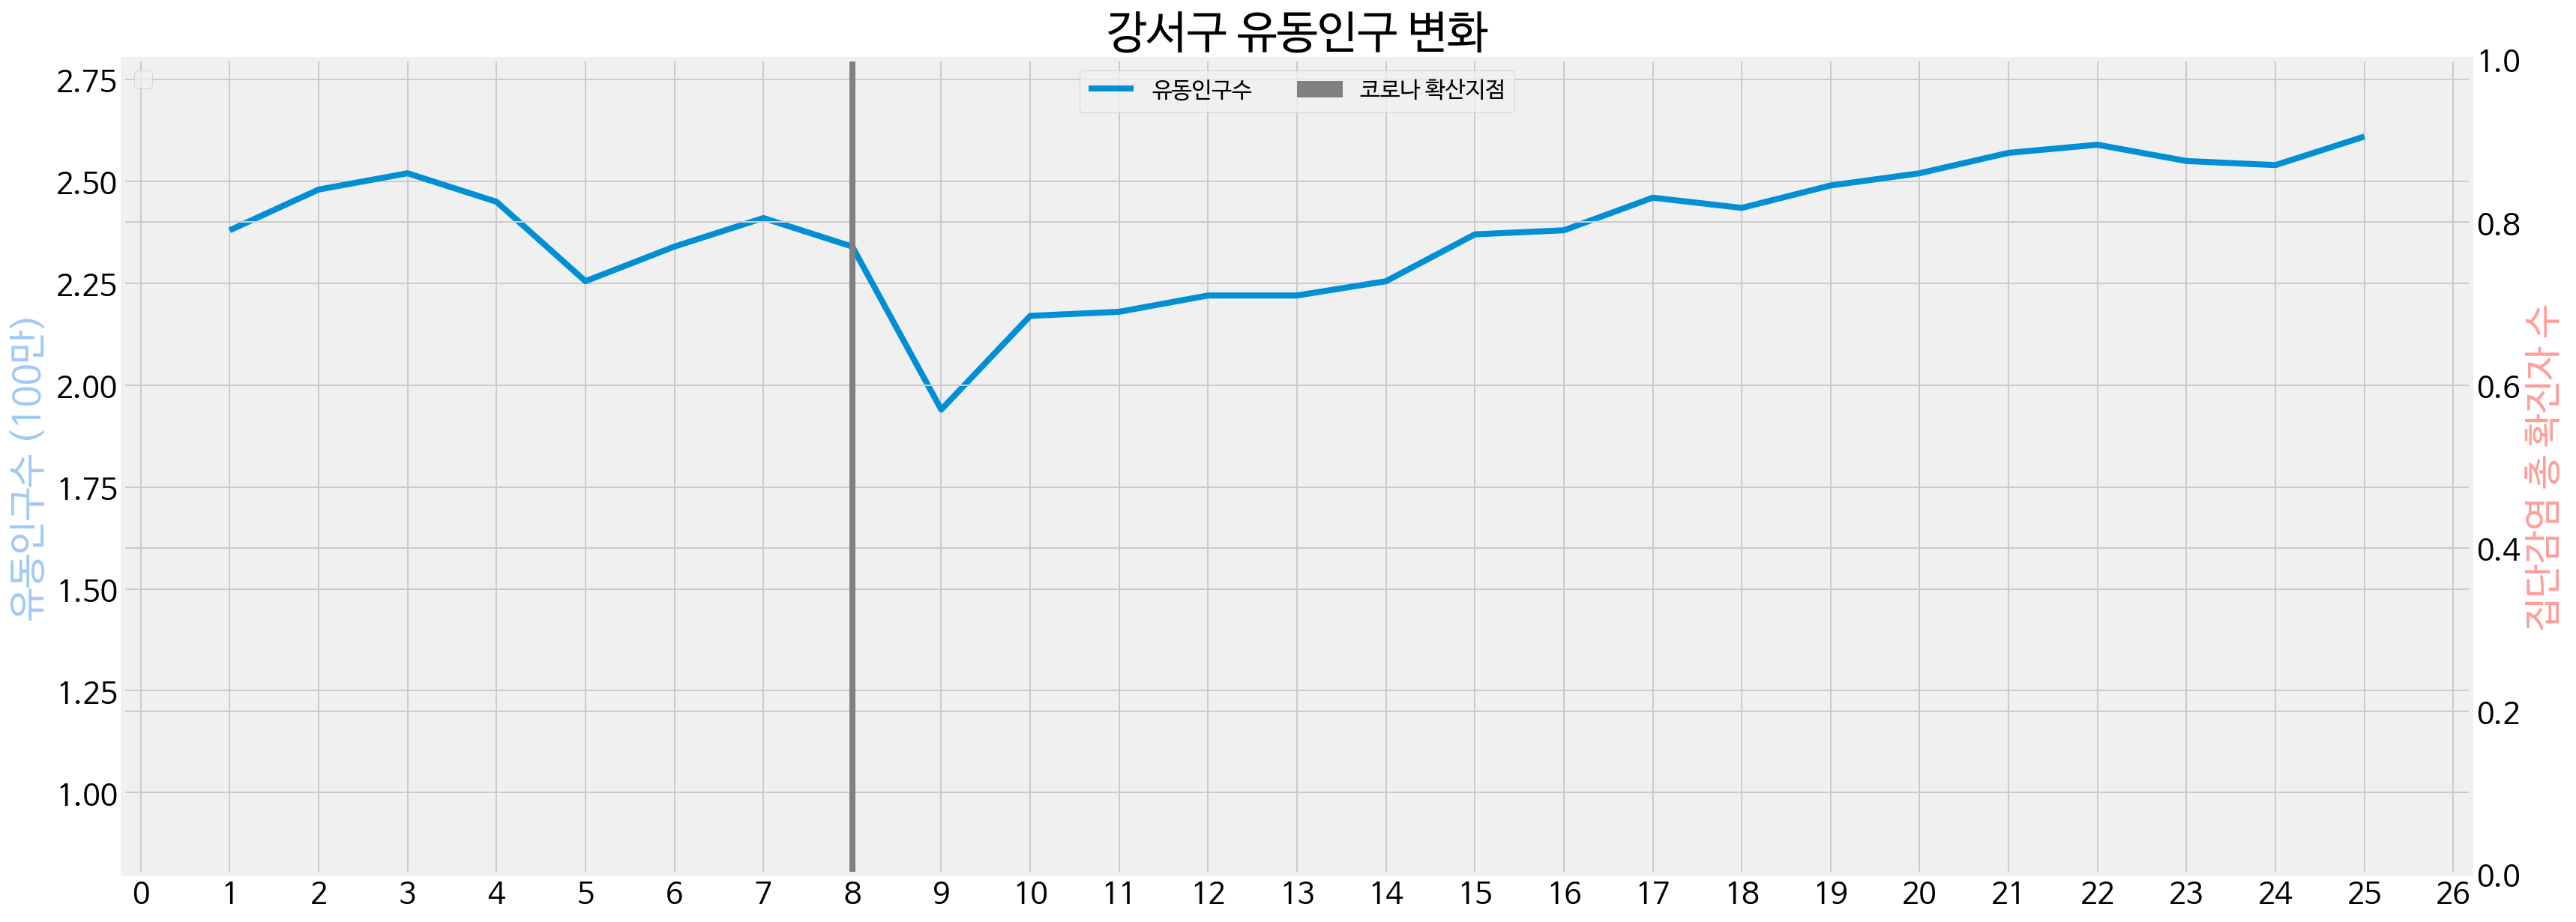

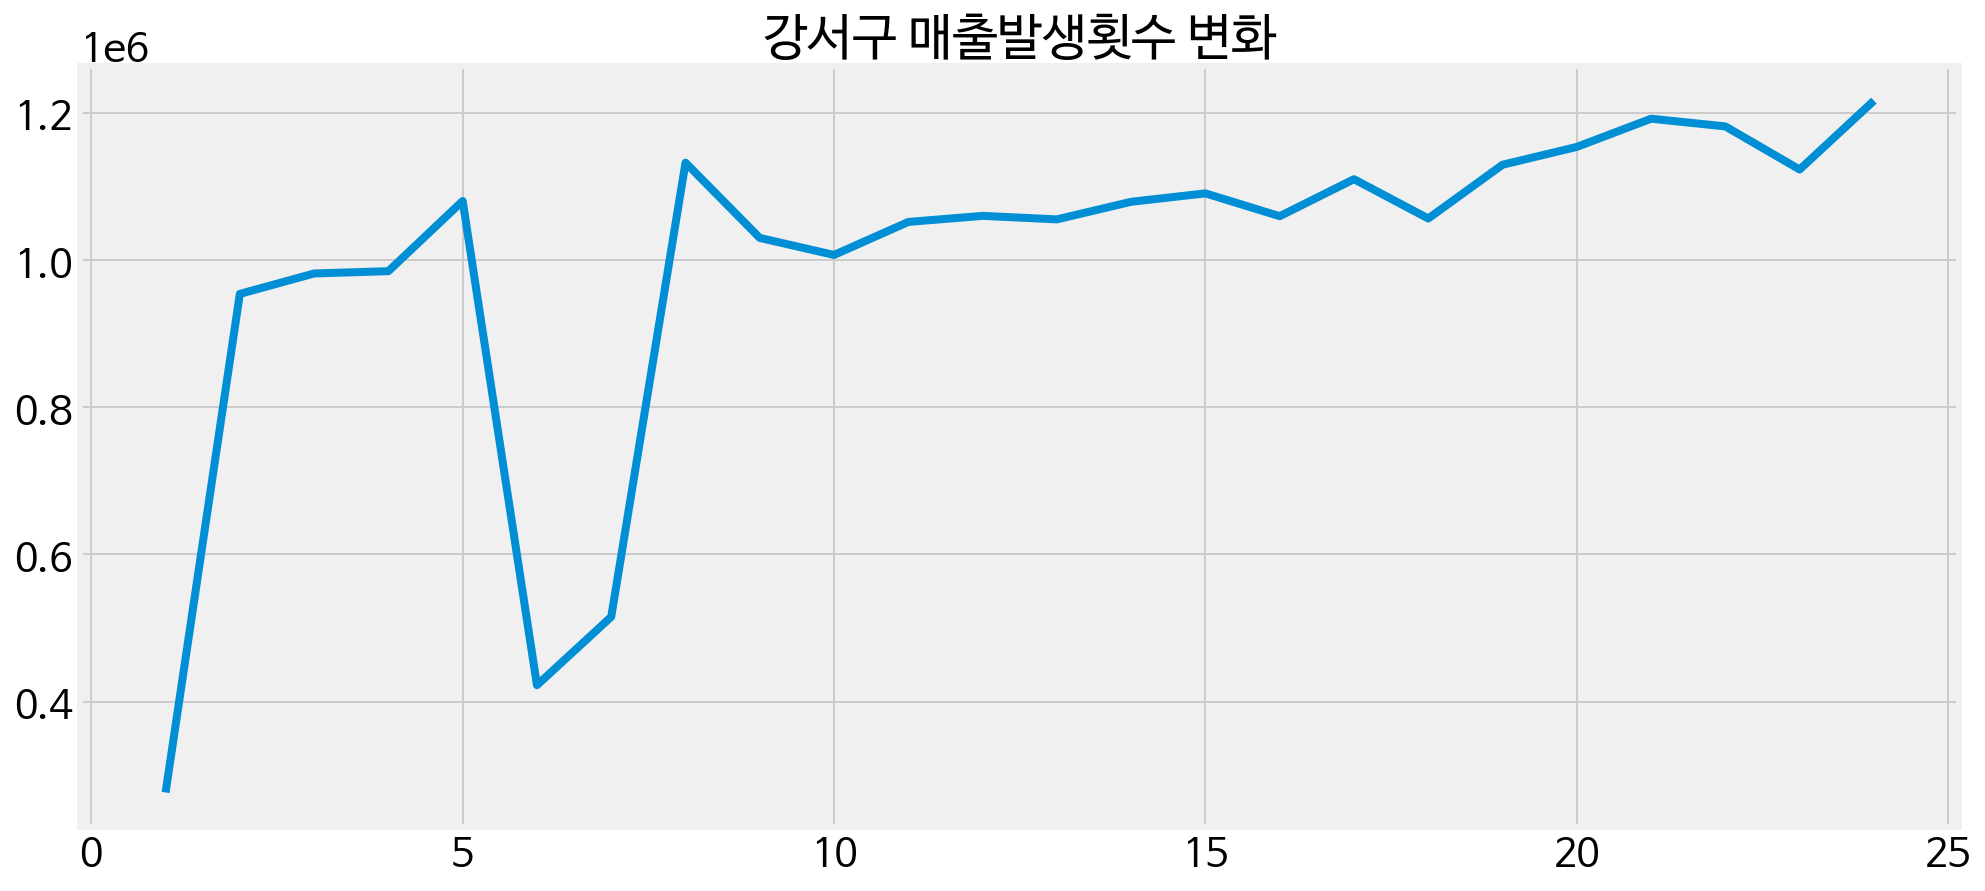

In [ ]:
#강서구 유동인구
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="강서구")

#강서구 cgi 변화
index_region=index.loc[index['sigungu']=="강서구",:]
index_region=index_region[['date','cgi']]
index_region['cgi']=pd.to_numeric(index_region['cgi'])
index_region = index_region.groupby('date')['cgi'].mean().to_frame().reset_index()

fig = px.line(index_region, x='date', y='cgi', title = '강서구 cgi 변화')
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-02-18', x1= '2020-02-18',
    )
])
fig.show()

#강서구 cnt 변화
card_gwan=card_ad.loc[card_ad.자치구명=='강서구']
card_gwan=card_gwan[['주차','cnt']]
card_gwan['cnt']=pd.to_numeric(card_gwan['cnt'])
card_gwan=card_gwan.groupby('주차')['cnt'].sum().to_frame().reset_index()


#그래프 그리기
plt.rcParams['figure.figsize'] = (15,7)
fig = plt.figure()
plt.title("강서구 매출발생횟수 변화", fontsize=25)
plt.plot(card_gwan['주차'],card_gwan['cnt'])
fig.show()

강서구는 집단감염이 발생하지 않은 구역이지만 유동인구와 매출발생횟수 모두 18주차, 24주차에 전 주보다 하락했다. 
같은 시기에 하락세가 두 데이터에서 모두 나타나기 때문에 유동인구와 소비지수의 연관성이 존재함을 확인할 수 있다. 

2. 강동구

No handles with labels found to put in legend.


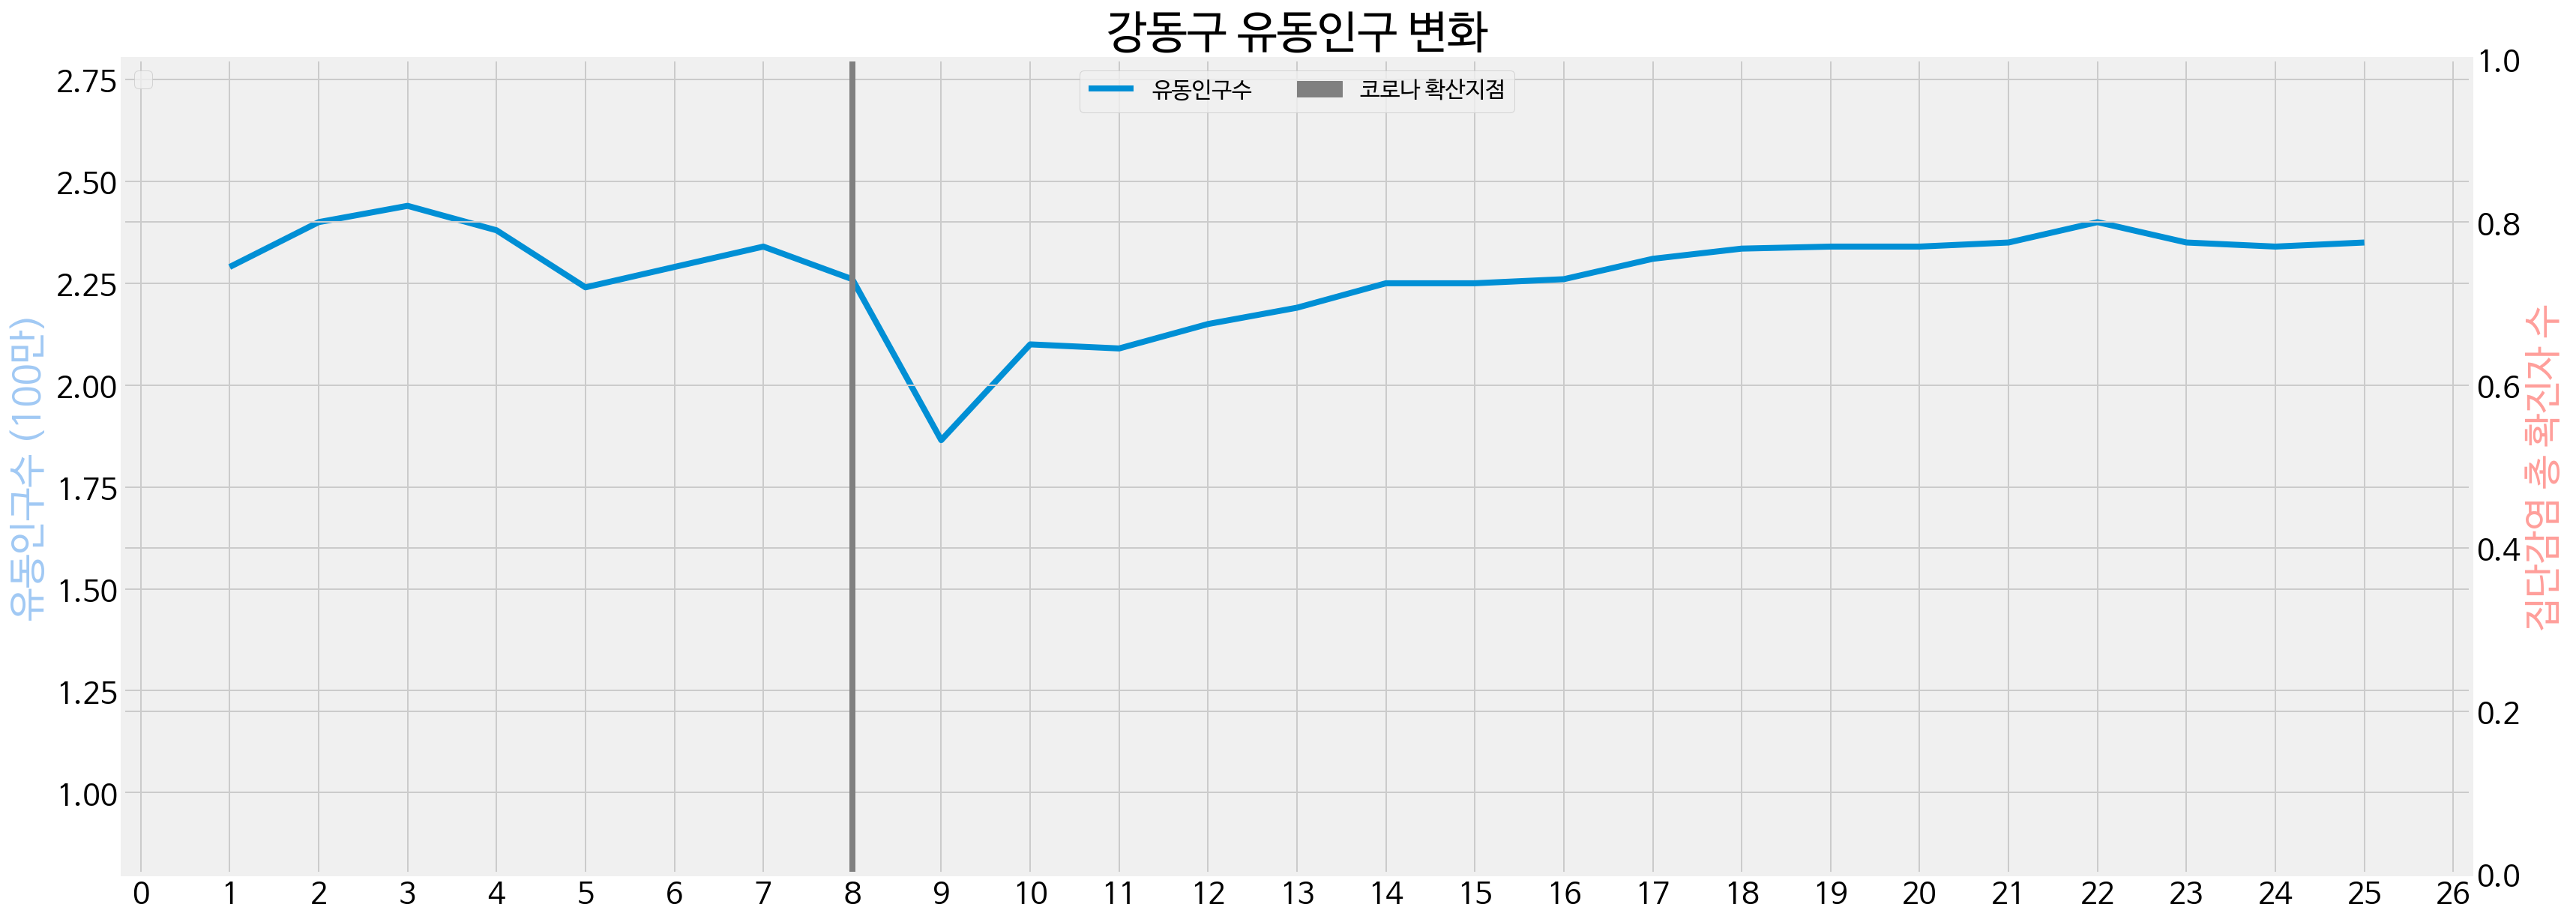

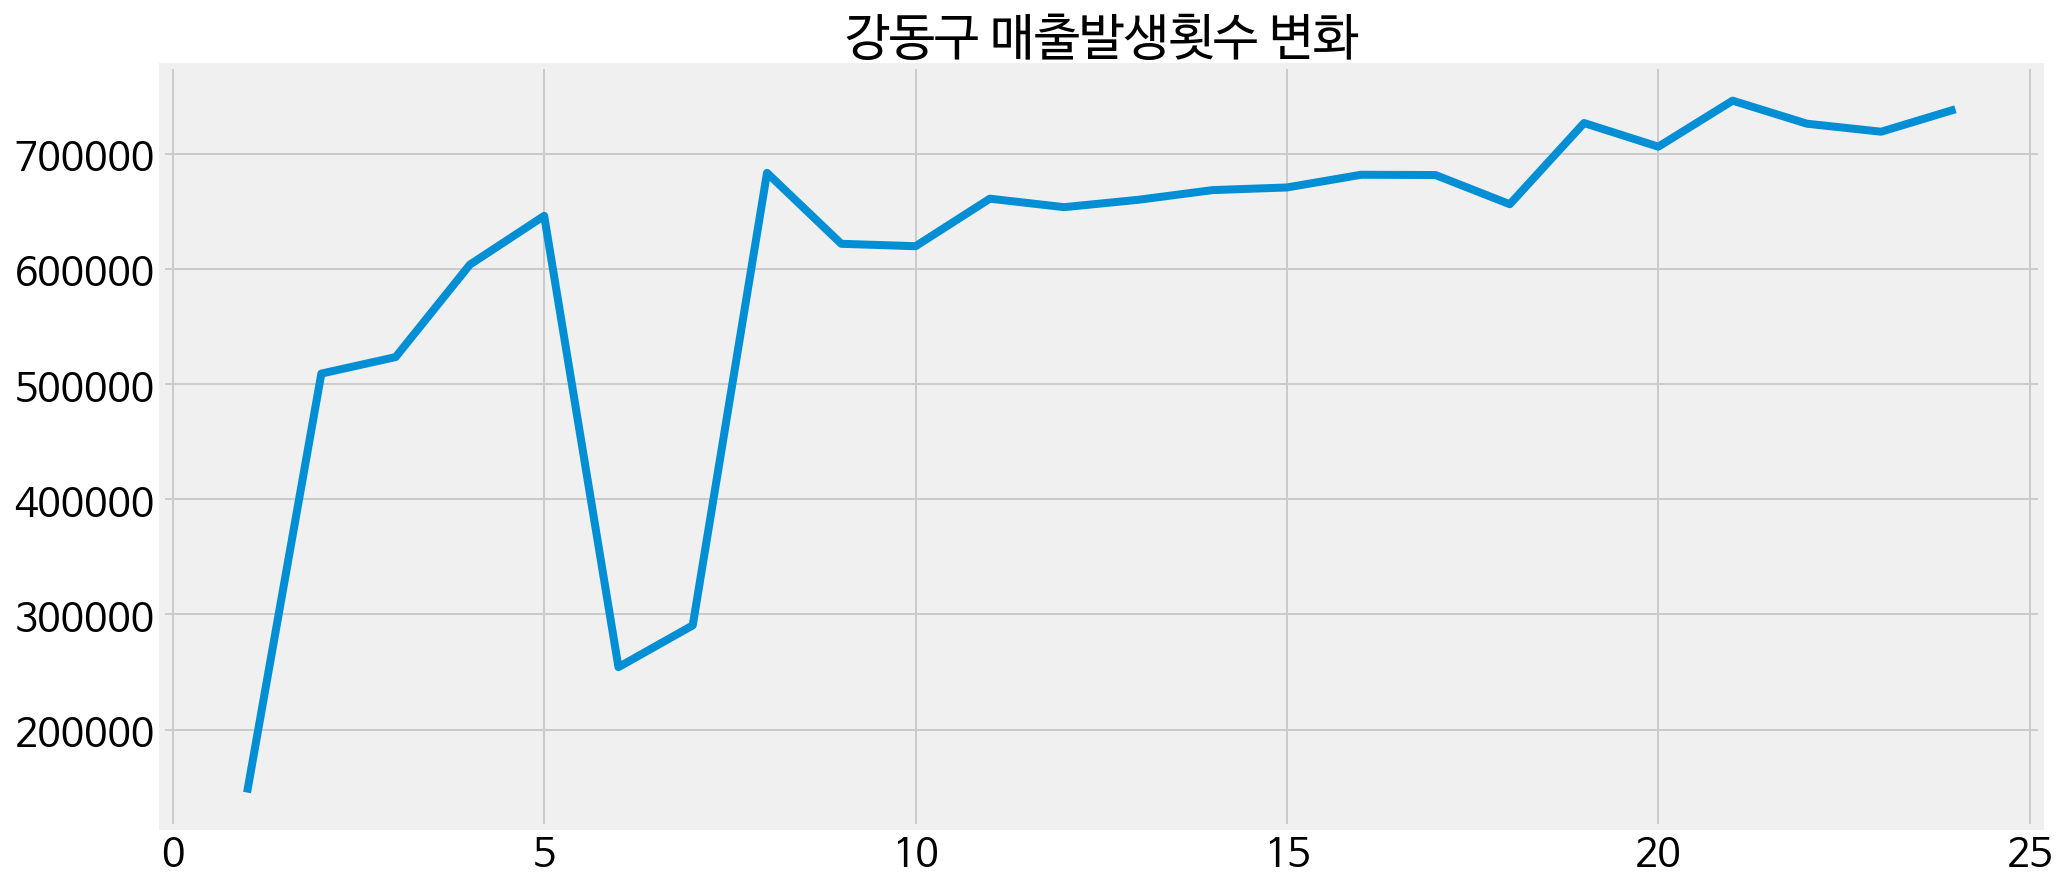

In [ ]:
#강동구 유동인구
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="강동구")

#강동구 cgi 변화
index_region=index.loc[index['sigungu']=="강동구",:]
index_region=index_region[['date','cgi']]
index_region['cgi']=pd.to_numeric(index_region['cgi'])
index_region = index_region.groupby('date')['cgi'].mean().to_frame().reset_index()

fig = px.line(index_region, x='date', y='cgi', title = '강동구 cgi 변화')
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-02-18', x1= '2020-02-18',
    )
])
fig.show()

#강동구 cnt 변화
card_gwan=card_ad.loc[card_ad.자치구명=='강동구']
card_gwan=card_gwan[['주차','cnt']]
card_gwan['cnt']=pd.to_numeric(card_gwan['cnt'])
card_gwan=card_gwan.groupby('주차')['cnt'].sum().to_frame().reset_index()


#그래프 그리기
plt.rcParams['figure.figsize'] = (15,7)
fig = plt.figure()
plt.title("강동구 매출발생횟수 변화", fontsize=25)
plt.plot(card_gwan['주차'],card_gwan['cnt'])
fig.show()

강동구 또한 강서구와 마찬가지로 유동인구가 감소하는 경우는 집단감염 발생 구에 비해 적게 나타난다.
강서구와 마찬가지로 매출발생횟수가 18주차, 24주차에 전주 대비 감소했다. 

3. 강북구

No handles with labels found to put in legend.


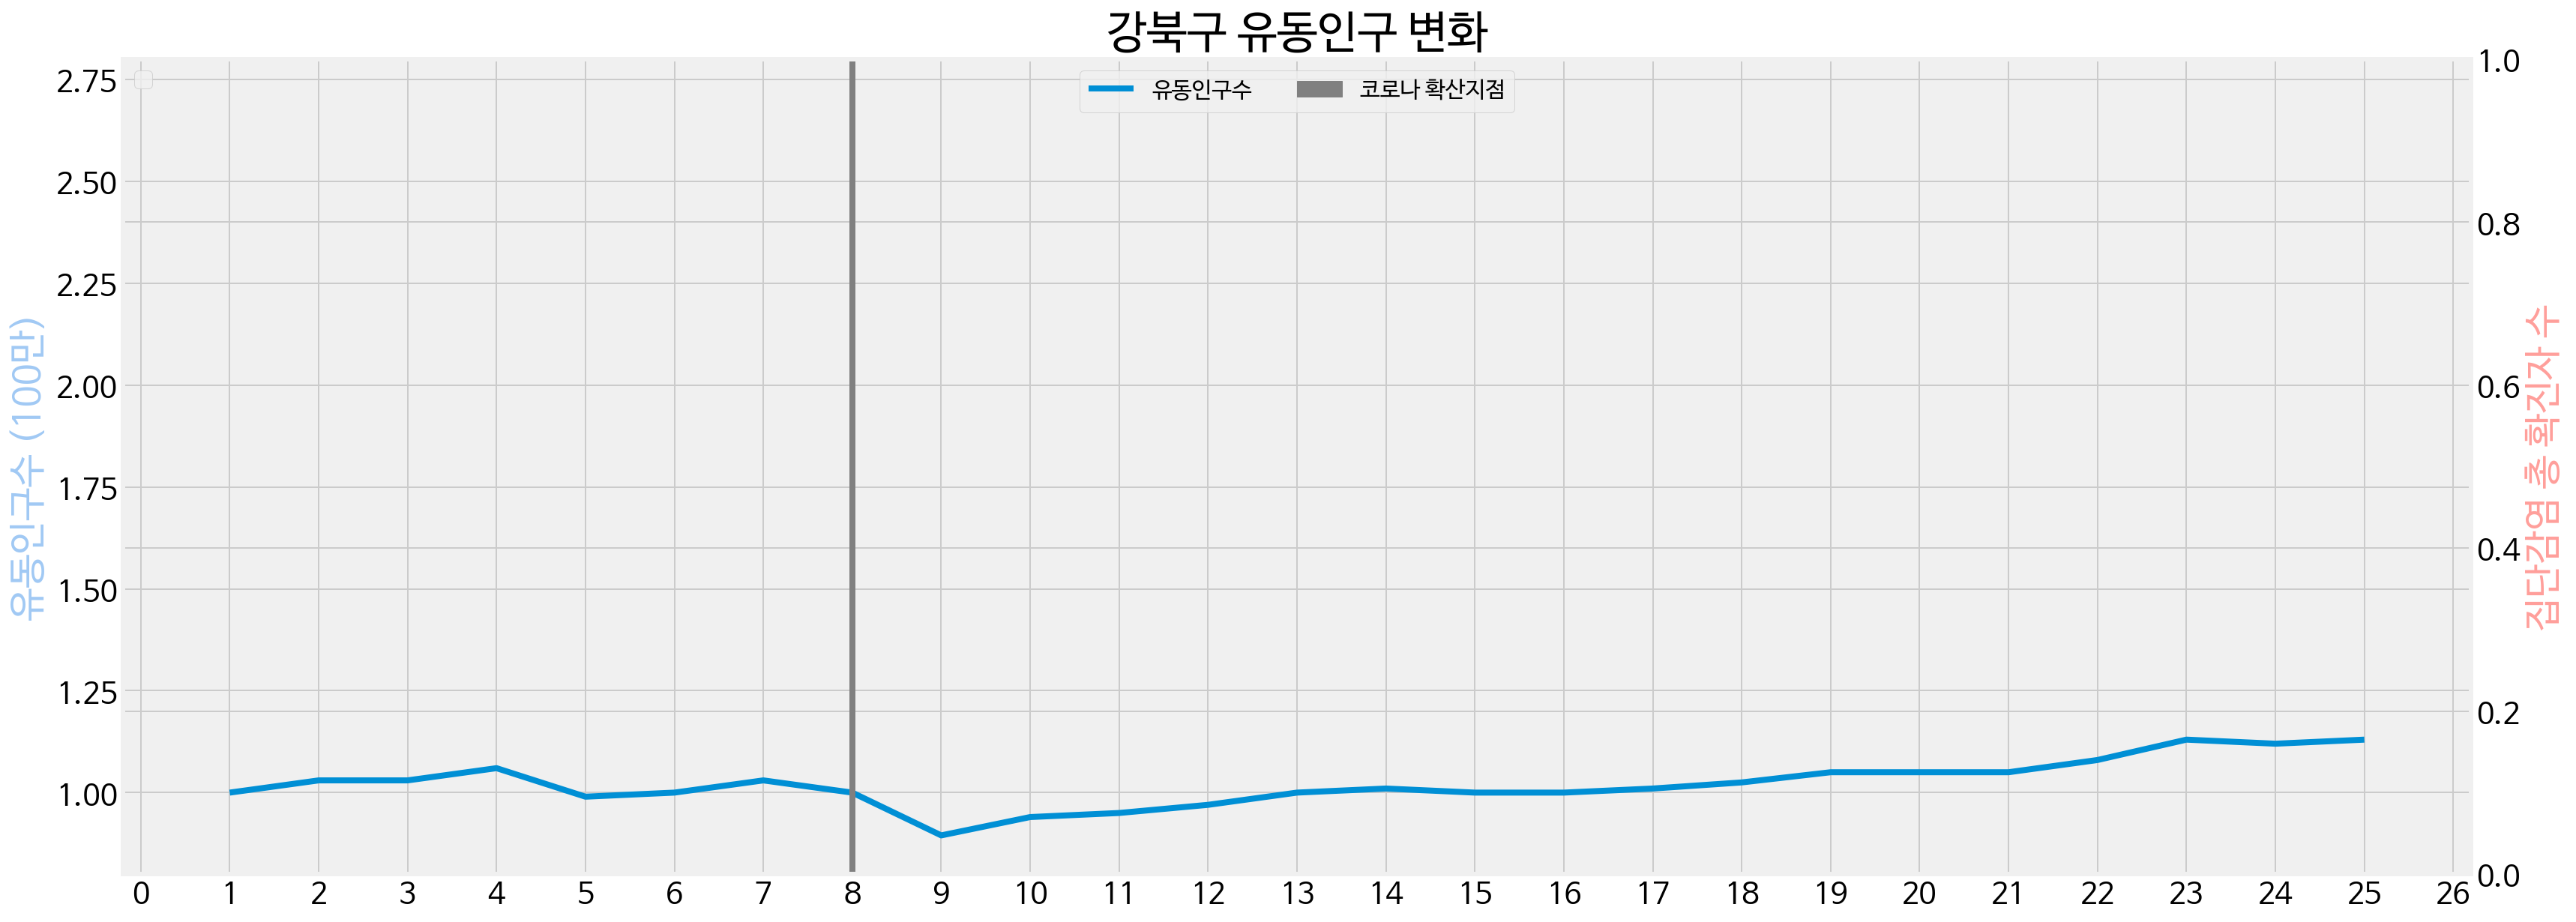

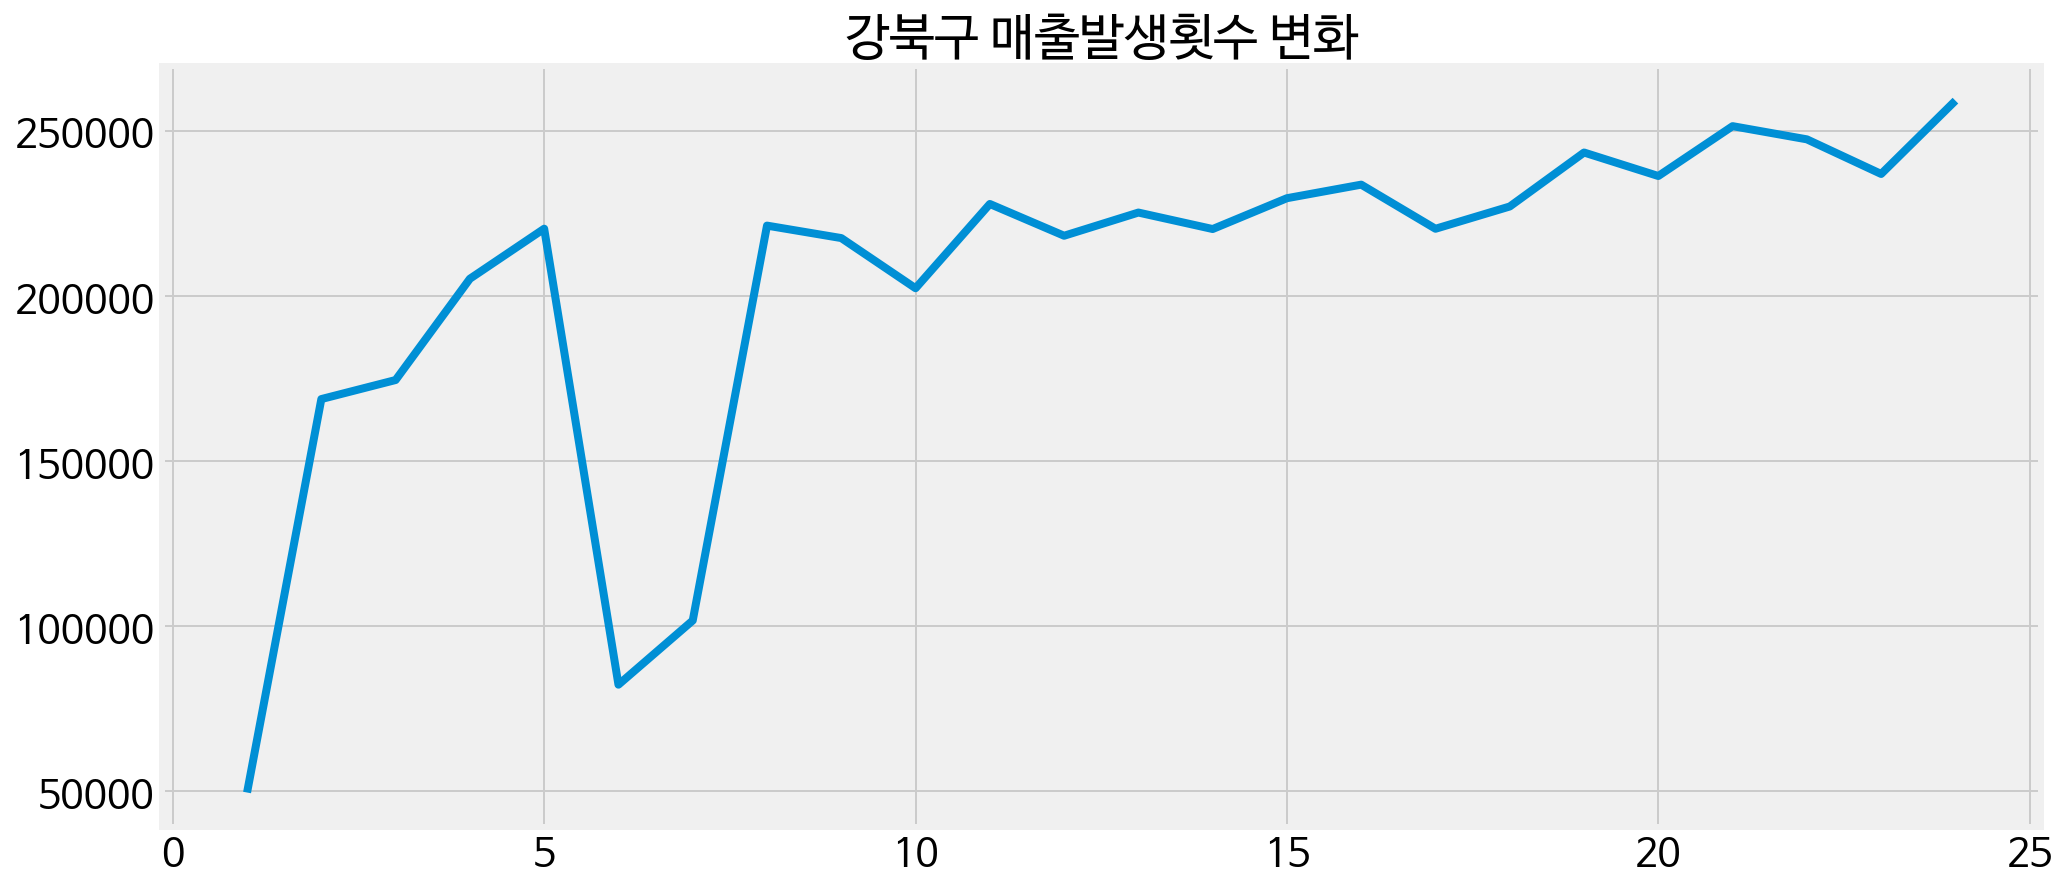

In [ ]:
#강북구 유동인구
plot_fpop_gu(new_fpop_seoul_gu,covid_case_seoul_mass_sorted_with_date,time_bin="주차", region="강북구")
#강북구 cgi 변화
index_region=index.loc[index['sigungu']=="강북구",:]
index_region=index_region[['date','cgi']]
index_region['cgi']=pd.to_numeric(index_region['cgi'])
index_region = index_region.groupby('date')['cgi'].mean().to_frame().reset_index()

fig = px.line(index_region, x='date', y='cgi', title = '강북구 cgi 변화')
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-02-18', x1= '2020-02-18',
    )
])
fig.show()

#강북구 cnt 변화
card_gwan=card_ad.loc[card_ad.자치구명=='강북구']
card_gwan=card_gwan[['주차','cnt']]
card_gwan['cnt']=pd.to_numeric(card_gwan['cnt'])
card_gwan=card_gwan.groupby('주차')['cnt'].sum().to_frame().reset_index()


#그래프 그리기
plt.rcParams['figure.figsize'] = (15,7)
fig = plt.figure()
plt.title("강북구 매출발생횟수 변화", fontsize=25)
plt.plot(card_gwan['주차'],card_gwan['cnt'])
fig.show()

강북구는 다른 구들과 비교하여 유동인구가 적고, 코로나 확산시점에 감소한 다음 24주차를 제외하고는 계속 증가추세를 이어갔다. 
매출발생횟수는 증가와 감소를 반복하지만 증가추세이다.


집단감염의 발생은 유동인구와 소비에 영향을 끼쳤다. 
집단감염 발생일에 해당 구의 유동인구와 매출발생횟수는 그 전주와 비교하여 감소하는 형태는 세 구역에서 공통적으로 나타났지만 다시 증가할 때까지 소요되는 기간은 달랐다. 
집단감염이 발생하지 않은 지역에서는 유동인구변화량이 발생한 구보다 적고 매출횟수감소폭도 적다.

집단감염의 발생 여부가 해당 구의 유동인구수와 소비심리에 영향을 주는 변수로 작용한 것을 확인했다. 
포스트코로나 시대에 비지니스들은 상권을 탐색할 때 각 구역의 집단감염 발생 여부와 집단감염 발생 확률에 대한 예측도 리스크관리에 포함시켜야 한다.